<a href="https://colab.research.google.com/github/pul35/Stock_market_forecasting/blob/main/stock_prediction_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import stock data
import time
import datetime
from datetime import date
import pandas as pd

today = date.today()
year =int(today.strftime("%Y"))
month = int(today.strftime("%m"))
day = int(today.strftime("%d"))


ticker = 'VOLCAR-B'
period1 = int(time.mktime(datetime.datetime(2021, 10, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(year, month, day, 23, 59).timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}.ST?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

sd = pd.read_csv(query_string) #Stock data
#df.to_csv('AAPL.csv')
sd.tail()

 

,Date,Open,High,Low,Close,Adj Close,Volume
113,2022-04-11,68.570000,70.790001,67.300003,68.900002,68.900002,1789826
114,2022-04-12,68.690002,70.690002,67.809998,69.809998,69.809998,1638694
115,2022-04-13,70.400002,70.489998,66.699997,67.779999,67.779999,1761899
116,2022-04-14,68.519997,68.910004,67.239998,68.910004,68.910004,1027732
117,2022-04-19,67.459999,70.830002,66.699997,70.300003,70.300003,1544160


<Figure size 432x288 with 0 Axes>

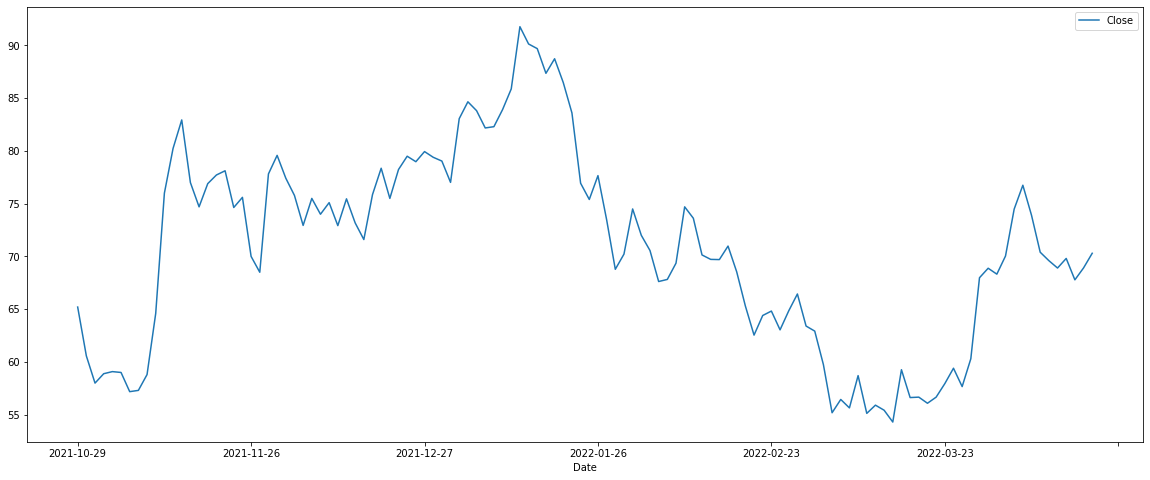

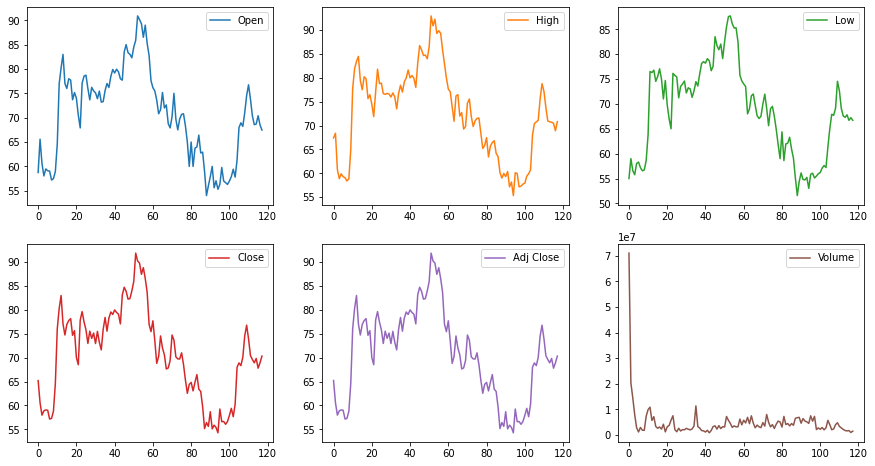

In [ ]:
# Plot stock data

import matplotlib.pyplot as plt

plt.figure()
sd.plot(x = 'Date', y = 'Close', figsize=(20,8), x_compat=True)

sd.plot(subplots=True, layout=(2, 3), figsize=(15, 8), sharex=False);



In [ ]:
import math

#math.asin(400/1012)

l1 = 390 + 260
l2 = 1140


math.degrees(math.atan(l1/l2))


29.690726512016813

In [ ]:
# Pre processing data


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Scaling data between [0 ,1]

sd_close = sd.reset_index()['Close']

scaler = MinMaxScaler(feature_range=(0,1))
sd_close = scaler.fit_transform(np.array(sd_close).reshape(-1,1))

# Splitting data set into train data & test data

ratio = 0.70        #Splitting ratio
train_size = round(len(sd_close) * ratio)
train_data, test_data = sd_close[0:train_size, :], sd_close[train_size:len(sd_close), :]

#print(test_data.shape)

# CREATE DATA SET WITH TIMESTEP
# ex: X = t, t+1, t+3      Y = t+4

def create_dataset(data, timestep):
  data_X = []
  data_Y =[]
  for i in range(len(data)-timestep):
    a= data[i: (i+timestep),0]
    b = data[i+timestep, 0]
    data_X.append([a])
    data_Y.append(b)
  return np.array(data_X), np.array(data_Y)





In [ ]:
# Generate data to feed into the model

timestep = 5
X_train, Y_train = create_dataset(train_data, timestep)
X_test, Y_test = create_dataset(test_data, timestep)

print(Y_train.shape)



(78,)


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from utils import data_string_to_float, status_calc


# The percentage by which a stock has to beat the S&P500 to be considered a 'buy'
OUTPERFORMANCE = 10


def build_data_set():
    """
    Reads the keystats.csv file and prepares it for scikit-learn
    :return: X_train and y_train numpy arrays
    """
    training_data = pd.read_csv("keystats.csv", index_col="Date")
    training_data.dropna(axis=0, how="any", inplace=True)
    features = training_data.columns[6:]

    X_train = training_data[features].values
    # Generate the labels: '1' if a stock beats the S&P500 by more than 10%, else '0'.
    y_train = list(
        status_calc(
            training_data["stock_p_change"],
            training_data["SP500_p_change"],
            OUTPERFORMANCE,
        )
    )

    return X_train, y_train


def predict_stocks():
    X_train, y_train = build_data_set()
    # Remove the random_state parameter to generate actual predictions
    clf = RandomForestClassifier(n_estimators=100, random_state=0)
    clf.fit(X_train, y_train)

    # Now we get the actual data from which we want to generate predictions.
    data = pd.read_csv("forward_sample.csv", index_col="Date")
    data.dropna(axis=0, how="any", inplace=True)
    features = data.columns[6:]
    X_test = data[features].values
    z = data["Ticker"].values

    # Get the predicted tickers
    y_pred = clf.predict(X_test)
    if sum(y_pred) == 0:
        print("No stocks predicted!")
    else:
        invest_list = z[y_pred].tolist()
        print(
            f"{len(invest_list)} stocks predicted to outperform the S&P500 by more than {OUTPERFORMANCE}%:"
        )
        print(" ".join(invest_list))
        return invest_list


if __name__ == "__main__":
    print("Building dataset and predicting stocks...")
    predict_stocks()


ModuleNotFoundError: ignored